<a href="https://colab.research.google.com/github/LeoFernanndes/notebooks/blob/master/titanic_data_manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
!git clone https://github.com/LeoFernanndes/functions

fatal: destination path 'functions' already exists and is not an empty directory.


In [0]:
import pandas as pd
import numpy as np


url_train = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/titanic_%20train.csv'
url_test = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/titanic_test.csv'

columns_order = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived']

train = pd.read_csv(url_train).reindex(columns_order, axis= 1)
test = pd.read_csv(url_test).reindex(columns_order.remove('Survived'), axis= 1)

dataframe = train.append(test, sort= False).set_index(np.arange(0,1309))

In [58]:
dataframe

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,NaN
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,NaN
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,NaN
1307,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,NaN


In [59]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Survived       891 non-null float64
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


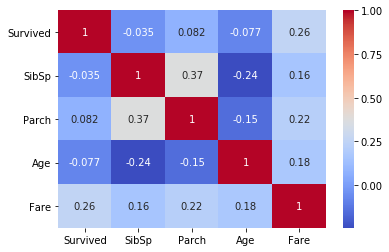

In [60]:
import seaborn as sns


g = sns.heatmap(dataframe[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, cmap = "coolwarm")

In [61]:
features = ['Pclass','Sex', 'SibSp', 'Parch', 'Embarked']

for feature in features:
  print(dataframe.groupby(by= [feature]).mean()['Survived'], '\n')

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64 

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64 

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64 

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
9         NaN
Name: Survived, dtype: float64 

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64 



In [0]:
dataframe['Fare'].fillna(dataframe['Fare'].median(), inplace= True)
dataframe['Embarked'].fillna('S', inplace= True)
dataframe['Cabin'].fillna('Unknown', inplace= True)
dataframe['Title'] = [name.split(',')[1].split('.')[0] for name in dataframe['Name']]

ages = dataframe.groupby(by= ['Title']).mean()['Age']
for title in ages.index:
  mask = dataframe['Title'] == title
  dataframe.loc[mask, 'Age'] = dataframe.loc[mask, 'Age'].fillna(value= dataframe.loc[dataframe['Title'] == title]['Age'].mean())

In [0]:
from functions import data_preprocessing


x = dataframe.drop(['Survived'], axis= 1)
y = train['Survived']

data_preprocessing.naive_data_preparation(x)

In [64]:
x.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,3,155,1,22.0,1,0,720,7.2500,186,2,12
1,2,1,286,0,38.0,1,0,816,71.2833,106,0,13
2,3,3,523,0,26.0,0,0,914,7.9250,186,2,9


In [65]:
from sklearn.model_selection import cross_val_score
from xgboost  import XGBClassifier


#colunas = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch','Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived', 'Title']
colunas = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked','Title']



x_train_cv = x.iloc[0: 891]
y_train_cv = y

clf = XGBClassifier()

cross_val_score(clf, x_train_cv, y_train_cv, cv= 10, scoring= 'accuracy')


array([0.84444444, 0.82222222, 0.7752809 , 0.80898876, 0.85393258,
       0.82022472, 0.82022472, 0.80898876, 0.83146067, 0.875     ])

In [66]:
from sklearn.model_selection import cross_val_score
from xgboost  import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

x_train = x.iloc[0: 600]
y_train = y.iloc[0: 600]

x_test = x.iloc[600:891]
y_test = y.iloc[600:891]

clf = DecisionTreeClassifier(max_depth= 3)


print('Accuracy: {}, f1: {}'.format(cross_val_score(clf, x_train[colunas], y_train, cv= 10, scoring= 'accuracy').mean(),
      cross_val_score(clf, x_train[colunas], y_train, cv= 10, scoring= 'f1').mean()))


Accuracy: 0.8051486524034456, f1: 0.6984832641914679


In [67]:
from sklearn.metrics import accuracy_score, f1_score


clf.fit(x_train[colunas], y_train)
y_pred = clf.predict(x_test[colunas])

print('Accuracy: {}, f1: {}'.format(accuracy_score(y_pred, y_test), f1_score(y_pred, y_test)))

Accuracy: 0.8350515463917526, f1: 0.7391304347826088


In [0]:
clf.fit(x_train_cv, y_train_cv)
y_envio = clf.predict(x.iloc[891:])

In [0]:
envio = pd.DataFrame({'PassengerId': x.iloc[891:]['PassengerId'],
                      'Survived': y_envio}).set_index(['PassengerId'])

In [0]:
from google.colab import files


envio.to_csv('titanic_submission_5.csv')